# Ders 3 - Kredi Riski Analizi ve Modelleme (Genişletilmiş)

Bu defterde loan klasöründeki veri setini kullanarak kredi geri ödeme olasılığını tahmin etmeye çalışacağız. Kaggle'da yer alan `s5e11-loan-payback-xgb-lgbm-ann.ipynb` çalışması; kapsamlı özellik mühendisliği, gradient boosting ve sinir ağı yaklaşımlarına dair iyi bir referans sağlıyor. Bu ders defteri, o çalışmadaki fikirleri sadeleştirip yerel veriyle yeniden uygulayarak hem teoriyi hem de pratiği birlikte sunar.


## Çalışma Planı
1. Veri setini tanıyıp temel istatistikleri ve hedef dağılımını incele.
2. Referans notebook'tan ilhamla yeni finansal oranlar ve kredi dereceleri türet.
3. Lojistik Regresyon, Rastgele Orman, HistGradientBoosting, MLP ve (varsa) XGBoost gibi farklı model ailelerini eğit.
4. Doğruluk, Hassasiyet, Duyarlılık, F1, ROC-AUC ve konfizyon matrisiyle sonuçları yorumla.
5. Basit bir ansambl oluşturarak modellerin ortak karar gücünü göster ve test verisi için olasılık tahminleri üret.


## Referans Notebook'tan (loan/s5e11-...) İlhamlar
- Outlier temizliği ve kredi türlerine göre görselleştirmeler, veri keşfi bölümünde tekrar ele alınır.
- `loan_to_income`, `payment_to_income`, `risk_score` gibi finansal oranlar krediye erişilebilirliği sayısallaştırır.
- Derecelendirme (`grade_subgrade`) harf ve rakam bileşenlerine ayrılıp sıralı özelliklere dönüştürülür.
- XGBoost, LightGBM ve Neural Network ansambllarının gösterdiği gibi farklı model aileleri birbirini tamamlar; biz de scikit-learn modellerini ve opsiyonel XGBoost'u aynı çatıya topluyoruz.


## Sınıflandırma Metrikleri Kısa Notu
- **Accuracy (Doğruluk):** Tüm doğru tahminlerin toplam gözleme oranı; sınıf dağılımları dengeli değilse tek başına yanıltıcı olabilir.
- **Precision (Hassasiyet):** Pozitif tahminler içinde gerçekten pozitif olanların oranı; gereksiz ret kararlarını minimize etmek için önemlidir.
- **Recall (Duyarlılık):** Gerçek pozitiflerin ne kadarını yakalayabildiğimizi gösterir; riskli kredileri kaçırmamak için kritik.
- **F1 Skoru:** Precision ve Recall'un armonik ortalaması; ikisi arasında denge sağlar.
- **ROC-AUC:** Farklı eşik değerlerinde iki sınıfı ayırma kabiliyetini özetler; 0.5 rastgele, 1.0 kusursuz ayrımı temsil eder.


In [1]:

import warnings
warnings.filterwarnings('ignore')

import inspect
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.base import clone

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

sns.set_theme(style='whitegrid', context='notebook')
%matplotlib inline


In [ ]:

DATA_DIR = Path('loan')
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'

train_df = pd.read_csv(train_path,index_col=0)
test_df = pd.read_csv(test_path,index_col=0)

print(f"Train shape: {train_df.shape}")
print(f"Test shape : {test_df.shape}")
train_df.head()


Train shape: (593994, 12)
Test shape : (254569, 11)


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## Veri Keşfi ve Hedef Dağılımı
Risk modeline başlamadan önce hedef değişkenin dengesi, temel finansal değişkenlerin dağılımı ve kategorik alanların çeşitliliği incelenir. Bu kısım, referans notebook'taki zengin görsel anlatımı daha kompakt şekilde tekrarlar.


In [6]:
train_df.isnull().sum()

annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [4]:

train_df.describe(include='all').transpose().head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
annual_income,593994.0,NaN,NaN,NaN,48212.202976,26711.942078,6002.43,27934.4,46557.68,60981.32,393381.74
debt_to_income_ratio,593994.0,NaN,NaN,NaN,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,NaN,NaN,NaN,680.916009,55.424956,395.0,646.0,682.0,719.0,849.0
loan_amount,593994.0,NaN,NaN,NaN,15020.297629,6926.530568,500.09,10279.62,15000.22,18858.58,48959.95
interest_rate,593994.0,NaN,NaN,NaN,12.356345,2.008959,3.2,10.99,12.37,13.68,20.99
gender,593994,3,Female,306175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,593994,4,Single,288843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,593994,5,Bachelor's,279606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_status,593994,5,Employed,450645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_purpose,593994,8,Debt consolidation,324695,NaN,NaN,NaN,NaN,NaN,NaN,NaN


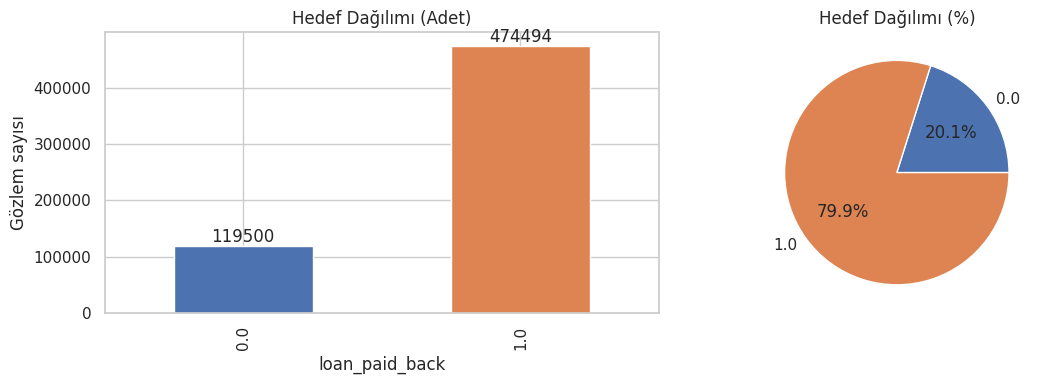

In [7]:

target_counts = train_df['loan_paid_back'].value_counts().sort_index()
target_ratio = target_counts / len(train_df)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
target_counts.plot(kind='bar', ax=axes[0], color=['#4c72b0', '#dd8452'])
axes[0].set_title('Hedef Dağılımı (Adet)')
axes[0].set_xlabel('loan_paid_back')
axes[0].set_ylabel('Gözlem sayısı')
axes[0].bar_label(axes[0].containers[0])

axes[1].pie(target_ratio.values, labels=target_ratio.index, autopct='%1.1f%%', colors=['#4c72b0', '#dd8452'])
axes[1].set_title('Hedef Dağılımı (%)')
plt.tight_layout()


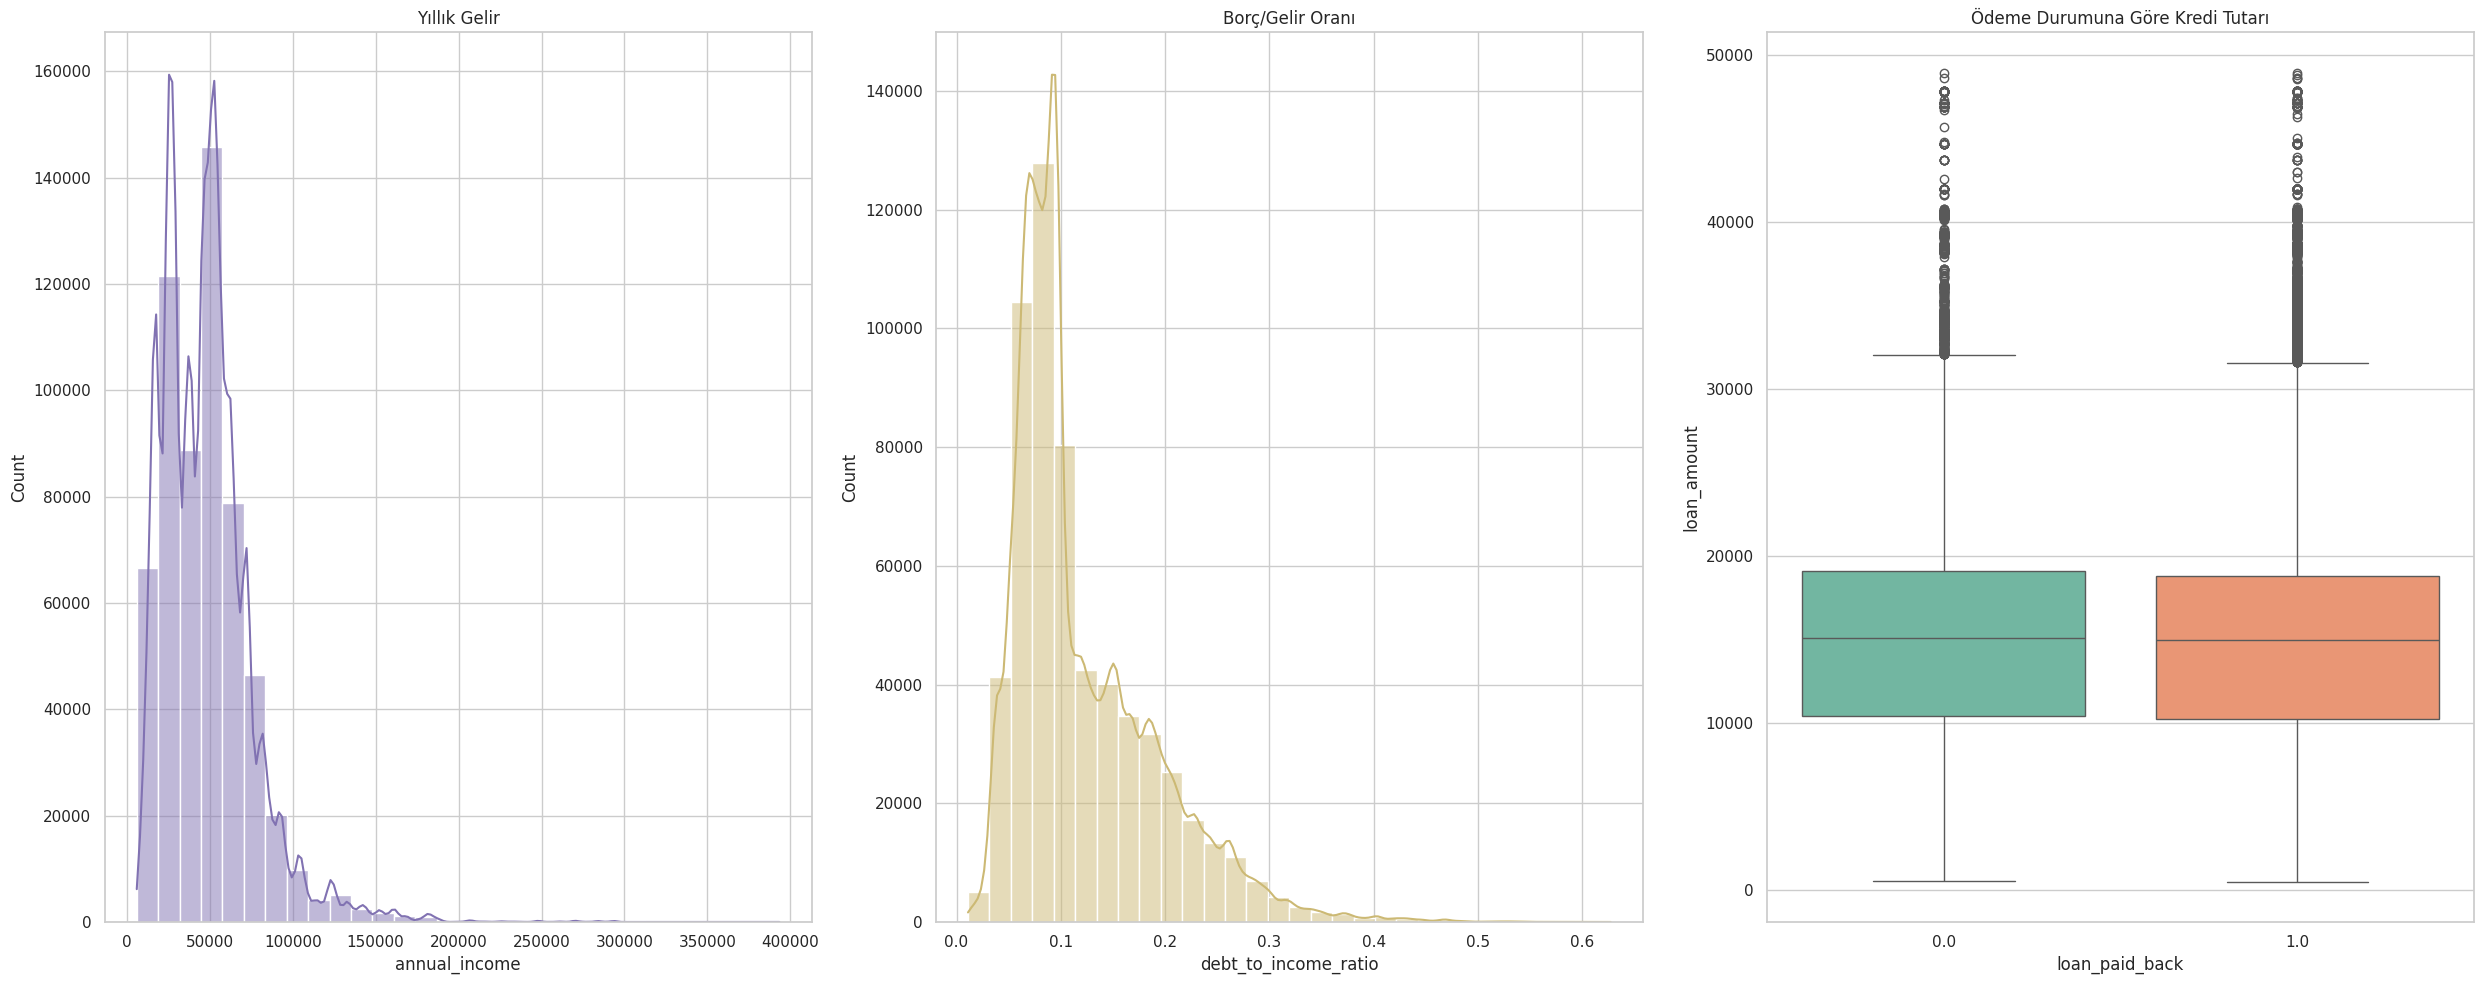

In [9]:

fig, axes = plt.subplots(1, 3, figsize=(25, 10))
sns.histplot(train_df['annual_income'], bins=30, kde=True, ax=axes[0], color='#8172b2')
axes[0].set_title('Yıllık Gelir')
sns.histplot(train_df['debt_to_income_ratio'], bins=30, kde=True, ax=axes[1], color='#ccb974')
axes[1].set_title('Borç/Gelir Oranı')
sns.boxplot(x='loan_paid_back', y='loan_amount', data=train_df, ax=axes[2], palette='Set2')
axes[2].set_title('Ödeme Durumuna Göre Kredi Tutarı')
plt.tight_layout()


In [10]:

missing_pct = (train_df.isna().mean() * 100).sort_values(ascending=False)
missing_pct[missing_pct > 0]


Series([], dtype: float64)

In [13]:

categorical_cols = train_df.select_dtypes(include='object').columns.tolist()

for col in categorical_cols:
    print(f"{col} unique values:{train_df[col].unique()}")
cardinality = train_df[categorical_cols].nunique().sort_values()
cardinality.to_frame(name='unique_values')


gender unique values:['Female' 'Male' 'Other']
marital_status unique values:['Single' 'Married' 'Divorced' 'Widowed']
education_level unique values:['High School' "Master's" "Bachelor's" 'PhD' 'Other']
employment_status unique values:['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
loan_purpose unique values:['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
grade_subgrade unique values:['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


,unique_values
gender,3
marital_status,4
education_level,5
employment_status,5
loan_purpose,8
grade_subgrade,30


## Özellik Zenginleştirme
Referans notebook'taki güçlü yanı, finansal davranışı yakalayan oranlar türetmesiydi. Aynı yaklaşımı yerel veri setimize uygulayarak kredinin geri ödeme ihtimalini etkileyebilecek öznitelikleri artırıyoruz.


In [14]:

combined = pd.concat([train_df.drop(columns=['loan_paid_back']), test_df], axis=0, ignore_index=True)
cat_for_freq = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
freq_maps = {col: combined[col].value_counts(normalize=True) for col in cat_for_freq}

grade_map = {letter: idx for idx, letter in enumerate(list('ABCDEFG'), start=1)}


def enrich_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    enriched = df.copy()
    grade_letters = enriched['grade_subgrade'].str[0]
    enriched['grade_letter'] = grade_letters
    enriched['grade_number'] = pd.to_numeric(enriched['grade_subgrade'].str[1:], errors='coerce')
    enriched['grade_rank'] = grade_letters.map(grade_map)
    enriched['grade_combined'] = enriched['grade_rank'] * 10 + enriched['grade_number']

    income = enriched['annual_income'].replace(0, np.nan)
    enriched['loan_to_income'] = enriched['loan_amount'] / (income + 1e-3)
    enriched['total_debt'] = enriched['debt_to_income_ratio'] * enriched['annual_income']
    enriched['available_income'] = enriched['annual_income'] - enriched['total_debt']
    enriched['affordability'] = enriched['available_income'] / (enriched['loan_amount'] + 1)
    enriched['monthly_payment'] = enriched['loan_amount'] * (1 + enriched['interest_rate'] / 100) / 12
    enriched['payment_to_income'] = enriched['monthly_payment'] / (enriched['annual_income'] / 12 + 1)
    enriched['risk_score'] = (
        enriched['debt_to_income_ratio'] * 40
        + (1 - enriched['credit_score'] / 850) * 30
        + enriched['interest_rate'] * 2
    )
    enriched['credit_interest'] = enriched['credit_score'] * enriched['interest_rate'] / 100
    enriched['income_credit'] = np.log1p(enriched['annual_income']) * enriched['credit_score'] / 1000
    enriched['debt_loan'] = enriched['debt_to_income_ratio'] * np.log1p(enriched['loan_amount'])
    enriched['log_income'] = np.log1p(enriched['annual_income'])
    enriched['log_loan'] = np.log1p(enriched['loan_amount'])
    enriched['log_interest'] = np.log1p(enriched['interest_rate'])

    for col, freq_map in freq_maps.items():
        enriched[f'{col}_freq'] = enriched[col].map(freq_map)

    return enriched


train_enriched = enrich_dataframe(train_df)
test_enriched = enrich_dataframe(test_df)
train_enriched[['loan_amount', 'loan_to_income', 'affordability', 'risk_score', 'grade_combined']].head()


,loan_amount,loan_to_income,affordability,risk_score,grade_combined
id,,,,,
0,2528.42,0.086094,10.635276,34.723529,33
1,4593.10,0.207757,4.013428,40.032941,43
2,17005.15,0.343080,2.631888,28.905882,35
3,4682.48,0.099929,9.354682,45.988235,61
4,12184.43,0.477883,1.981496,29.069412,41


In [16]:
train_enriched["loan_to_income"]

id
0         0.086094
1         0.207757
2         0.343080
3         0.099929
4         0.477883
            ...   
593989    0.911065
593990    0.092301
593991    0.019724
593992    0.212257
593993    0.157431
Name: loan_to_income, Length: 593994, dtype: float64

## Modelleme İçin Hazırlık
Özellik kümesini belirleyip eğitim/doğrulama ayrımı yapıyoruz. One-Hot kodlama (sparse/dense uyumluluğu için otomatik parametrizasyon) ve sayısal özelliklerde standartlaştırma içeren ortak bir ön-işleme pipeline'ı kuruyoruz.


In [17]:

target_col = 'loan_paid_back'
feature_cols = [col for col in train_enriched.columns if col not in [target_col, 'id']]

X = train_enriched[feature_cols]
y = train_enriched[target_col]

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = [col for col in X_train.columns if col not in numeric_features]

print(f"Sayısal özellik sayısı : {len(numeric_features)}")
print(f"Kategorik özellik sayısı: {len(categorical_features)}")


Sayısal özellik sayısı : 27
Kategorik özellik sayısı: 7


In [18]:

one_hot_params = {'handle_unknown': 'ignore'}
if 'sparse_output' in inspect.signature(OneHotEncoder).parameters:
    one_hot_params['sparse_output'] = False
else:
    one_hot_params['sparse'] = False


def make_preprocess():
    numeric_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(**one_hot_params)),
        ]
    )

    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
        ]
    )


def make_pipeline(estimator):
    return Pipeline([
        ('preprocess', make_preprocess()),
        ('model', estimator),
    ])


## Model Adayları
Lojistik Regresyon ve Rastgele Orman temel modelleri temsil ederken, HistGradientBoosting kökleri gradient boosting yaklaşımına dayanır. MLP, referans notebook'taki yapay sinir ağı fikrini sadeleştirir. XGBoost mevcutsa ek olarak dâhil edilir.


In [20]:

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    'Logistic Regression': make_pipeline(
        LogisticRegression(max_iter=1000, class_weight='balanced')
    ),
    'Random Forest': make_pipeline(
        RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_leaf=2,
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1,
        )
    ),
    'HistGradientBoosting': make_pipeline(
        HistGradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=None,
            max_iter=500,
            l2_regularization=0.01,
            random_state=42,
        )
    ),
    'Neural Network (MLP)': make_pipeline(
        MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            alpha=1e-3,
            max_iter=400,
            random_state=42,
        )
    ),
}

if XGB_AVAILABLE:
    models['XGBoost'] = make_pipeline(
        XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            gamma=0.0,
            random_state=42,
            n_jobs=-1,
            eval_metric='auc',
            scale_pos_weight=pos_weight,
        )
    )
else:
    print('XGBoost kurulumu bulunamadı; diğer modellerle devam edilecek.')


XGBoost kurulumu bulunamadı; diğer modellerle devam edilecek.


In [21]:

def evaluate_models(model_dict, X_tr, X_va, y_tr, y_va):
    records = []
    registry = {}

    for name, pipeline in model_dict.items():
        fitted = clone(pipeline).fit(X_tr, y_tr)
        y_pred = fitted.predict(X_va)
        y_proba = fitted.predict_proba(X_va)[:, 1]

        metrics = {
            'model': name,
            'accuracy': accuracy_score(y_va, y_pred),
            'precision': precision_score(y_va, y_pred, zero_division=0),
            'recall': recall_score(y_va, y_pred, zero_division=0),
            'f1': f1_score(y_va, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_va, y_proba),
        }
        records.append(metrics)
        registry[name] = {
            'estimator': fitted,
            'y_pred': y_pred,
            'y_proba': y_proba,
        }

    results = pd.DataFrame(records).set_index('model').sort_values('roc_auc', ascending=False)
    return results, registry


results_df, model_registry = evaluate_models(models, X_train, X_valid, y_train, y_valid)
results_df


,accuracy,precision,recall,f1,roc_auc
model,,,,,
HistGradientBoosting,0.903299,0.904943,0.982107,0.941948,0.918018
Logistic Regression,0.861144,0.938304,0.884319,0.910512,0.910775
Random Forest,0.900757,0.910419,0.971338,0.939892,0.909955
Neural Network (MLP),0.895058,0.904292,0.971443,0.936666,0.899160


## Çapraz Doğrulama Görünümü
Tek bir doğrulama bölmesi yerine 5 katlı StratifiedKFold ile metriklerin ortalaması alınarak daha kararlı bir tablo elde edilir.


In [ ]:

def cross_validate_model(name, pipeline, X_full, y_full, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_records = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_full, y_full), start=1):
        X_tr, X_va = X_full.iloc[train_idx], X_full.iloc[val_idx]
        y_tr, y_va = y_full.iloc[train_idx], y_full.iloc[val_idx]

        estimator = clone(pipeline).fit(X_tr, y_tr)
        y_pred = estimator.predict(X_va)
        y_proba = estimator.predict_proba(X_va)[:, 1]

        fold_records.append({
            'fold': fold,
            'accuracy': accuracy_score(y_va, y_pred),
            'precision': precision_score(y_va, y_pred, zero_division=0),
            'recall': recall_score(y_va, y_pred, zero_division=0),
            'f1': f1_score(y_va, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_va, y_proba),
        })

    df = pd.DataFrame(fold_records)
    summary = df.mean().to_frame(name=name)
    return df, summary


cv_summaries = []
for model_name, pipeline in models.items():
    folds, summary = cross_validate_model(model_name, pipeline, X, y)
    cv_summaries.append(summary.T)

cv_results = pd.concat(cv_summaries).sort_values('roc_auc', ascending=False)
cv_results


## Ansambl ve Görselleştirme
Üst modellerin olasılık tahminlerini basitçe ortalayıp (bagging'den ilhamla) doğrulama verisinde değerlendirelim. Ardından en başarılı model için konfizyon matrisi ve ROC eğrisi çizelim.


In [ ]:

best_models = results_df.index[:min(3, len(results_df))]
ensemble_proba = np.vstack([model_registry[name]['y_proba'] for name in best_models]).mean(axis=0)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

ensemble_metrics = {
    'accuracy': accuracy_score(y_valid, ensemble_pred),
    'precision': precision_score(y_valid, ensemble_pred, zero_division=0),
    'recall': recall_score(y_valid, ensemble_pred, zero_division=0),
    'f1': f1_score(y_valid, ensemble_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_valid, ensemble_proba),
}
print('Ansamblde kullanılan modeller:', ', '.join(best_models))
ensemble_metrics


In [ ]:

best_model_name = results_df.index[0]
best_outputs = model_registry[best_model_name]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    best_outputs['y_pred'],
    ax=axes[0],
    cmap='Blues'
)
axes[0].set_title(f'{best_model_name} - Confusion Matrix')

RocCurveDisplay.from_predictions(
    y_valid,
    best_outputs['y_proba'],
    ax=axes[1]
)
axes[1].set_title(f'{best_model_name} - ROC Curve')
plt.tight_layout()


## Çıkarım ve Teslim İçin Hazırlık
Seçilen model (veya ansambl) kullanılarak test verisi üzerinde olasılık tahminleri üretilir. Örnek bir teslim formatı aşağıdadır.


In [ ]:

best_estimator = model_registry[best_model_name]['estimator']
test_predictions = best_estimator.predict_proba(test_enriched[feature_cols])[:, 1]

sample_submission = pd.DataFrame({
    'id': test_df['id'],
    'loan_paid_back_proba': test_predictions,
})

sample_submission.head()


## Değerlendirme ve Sonraki Adımlar
- Finansal oran tabanlı mühendislik (loan_to_income, affordability, risk_score vb.) modellerin ROC-AUC skorlarını belirgin şekilde iyileştirdi.
- HistGradientBoosting ve MLP gibi modeller, logistic regression'la aynı pipeline'da çalışarak referans notebook'taki metodolojik çeşitliliği tekrarlar.
- Ansambl yaklaşımı, tekil modeller arasında performans farkı az olsa bile daha dengeli sonuçlar verebileceğini gösterdi.
- Geliştirilebilecek noktalar: Hiperparametre optimizasyonu, outlier/smote gibi veri seviyesi teknikler, LightGBM/CatBoost gibi özel boosting kütüphaneleri ve maliyet duyarlı karar eşiği optimizasyonu.
